Importamos librerias necesarias.

In [1]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

Importamos tabla y eliminamos valores faltantes de en _TotalCharges_.
    * Creamos Churn_b con valores binarios.
    * Mezclamos el DataFrame para hacer los análisis.

In [2]:
df = pd.read_csv('data.csv')

df['TotalCharges'].replace(' ', np.nan, inplace=True)
df = df.dropna(subset = ['TotalCharges'])
df = df.sample(frac = 1
               , random_state = 12345)

df['Churn_b'] =  df.Churn.replace({"No": 0, "Yes": 1})
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Churn_b
3281,6322-PJJDJ,Male,0,Yes,No,49,Yes,No,Fiber optic,No,...,No,Yes,Yes,Two year,Yes,Electronic check,94.80,4690.65,No,0
1625,1262-OPMFY,Female,0,Yes,No,9,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Bank transfer (automatic),75.75,655.9,Yes,1
4606,1734-ZMNTZ,Female,0,Yes,Yes,11,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.00,300.7,No,0
5443,7109-MFBYV,Male,0,No,No,26,Yes,No,DSL,No,...,No,No,No,Month-to-month,No,Electronic check,45.45,1233.15,No,0
2762,8929-KSWIH,Male,0,No,No,25,Yes,No,Fiber optic,No,...,Yes,Yes,Yes,Two year,No,Bank transfer (automatic),99.30,2513.5,No,0


In [3]:
df_Churn = df.groupby(by = ['Churn'])['customerID'].count().reset_index()
df_Churn['Rat'] = df_Churn.customerID / df_Churn.customerID.sum()
df_Churn

,Churn,customerID,Rat
0,No,5163,0.734215
1,Yes,1869,0.265785


Función de contingencia para el cálculo de proporciones de las distintas variables

In [4]:
def contingencia(df, discreta):
    df_result = df.groupby([discreta])['Churn_b']
    a = df_result.sum() / df_result.count()
    
    return a.reset_index()

Creamos lista de columnas y eliminamos las que contienen datos numéricos.

In [5]:
columnsList = df.columns.tolist()

excluir = ['customerID','TotalCharges','tenure','MonthlyCharges','Churn','Churn_b']

for i in excluir:
    if i in columnsList:
        columnsList.remove(i)
        
print(columnsList)

['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [6]:
salto = '''------------------------------------
'''

for i in columnsList:
    print(salto, contingencia(df, i))

------------------------------------
    gender   Churn_b
0  Female  0.269595
1    Male  0.262046
------------------------------------
    SeniorCitizen   Churn_b
0              0  0.236503
1              1  0.416813
------------------------------------
   Partner   Churn_b
0      No  0.329761
1     Yes  0.197171
------------------------------------
   Dependents   Churn_b
0         No  0.312791
1        Yes  0.155312
------------------------------------
   PhoneService   Churn_b
0           No  0.250000
1          Yes  0.267475
------------------------------------
       MultipleLines   Churn_b
0                No  0.250812
1  No phone service  0.250000
2               Yes  0.286485
------------------------------------
   InternetService   Churn_b
0             DSL  0.189983
1     Fiber optic  0.418928
2              No  0.074342
------------------------------------
         OnlineSecurity   Churn_b
0                   No  0.417787
1  No internet service  0.074342
2                  Y

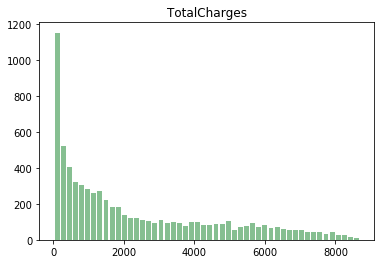

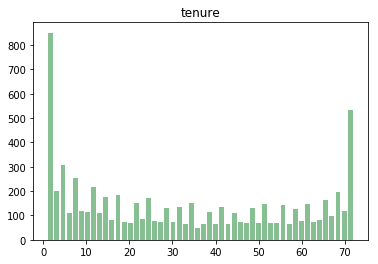

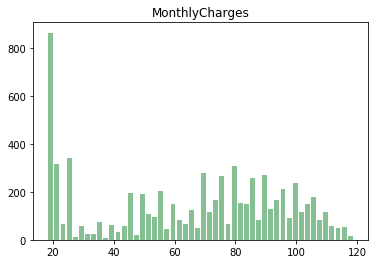

In [7]:
Var_Continuas = ['TotalCharges','tenure','MonthlyCharges']

for i in Var_Continuas:
    df[[i]].apply(pd.to_numeric).hist(bins = 50
                                      , grid = False
                                      , color = '#86bf91'
                                      , zorder = 2
                                      , rwidth = 0.8)
    plt.show

In [8]:
Peso_train = 0.6

df_train = df.head(int(df.customerID.count() * Peso_train))
df_test = df.tail(df.customerID.count() - int(df.customerID.count() * Peso_train))

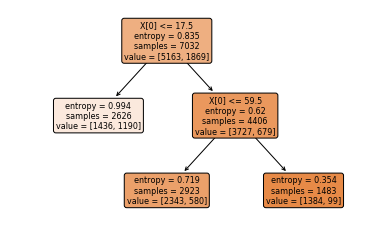

0.7354823417871533

In [9]:
X = df[['tenure']]
Y = df['Churn'] 

X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , Y
                                                    , test_size = 0.4
                                                    , random_state = 12345)

lr = tree.DecisionTreeClassifier(max_depth = 2, 
                                  min_samples_split = 3000,
                                  criterion='entropy')

lr = lr.fit(X, Y)
tree.plot_tree(lr
               , fontsize = 8
               , max_depth = 7
               , impurity = True
               , rounded = True
               , filled= True)

plt.show()
lr.score(X_train, Y_train)

### puntos de corte 17.5 y 61.5

In [10]:
df['Tenure_b'] = df.tenure.map(lambda x: 'bajo' if x <= 17.5 else ('medio' if x <= 59.5 else 'alto'))
columnsList.append('Tenure_b')

df.groupby(['Tenure_b'])['Churn_b'].count()

Tenure_b
alto     1483
bajo     2626
medio    2923
Name: Churn_b, dtype: int64

Creamos dummies con todas las variables discretas para poder lanzar la regresión logística.
    * LogisticRegression con el parámetro solver = 'lbfgs' para que no se muestre mensaje por pantalla.

In [11]:
Salto = '''
'''
X = pd.get_dummies (data = df[['gender'
                               , 'SeniorCitizen'
                               , 'Partner'
                               , 'Dependents'
                               , 'PhoneService'
                               , 'MultipleLines'
                               , 'InternetService'
                               , 'OnlineSecurity'
                               , 'OnlineBackup'
                               , 'DeviceProtection'
                               , 'TechSupport'
                               , 'StreamingTV'
                               , 'StreamingMovies'
                               , 'Contract'
                               , 'PaperlessBilling'
                               , 'PaymentMethod'
                               , 'Tenure_b']])
Y = df['Churn']

X_train, X_test, Y_train, Y_test = train_test_split(X
                                                    , Y
                                                    , test_size = 0.4
                                                    , random_state = 12345)

lr = LogisticRegression(solver = 'lbfgs')
lr.fit(X_train, Y_train)

Y_Pred = lr.predict(X_test)

print('Score:', lr.score(X_train, Y_train)
      , Salto, np.mean(Y_test == Y_Pred)
      , Salto, lr.intercept_ )

print(Salto, 'Matriz de confusión', Salto, confusion_matrix(Y_test, Y_Pred))

Score: 0.7994785494192936 
 0.79950231070032 
 [-2.21470219]

 Matriz de confusión 
 [[1875  185]
 [ 379  374]]
